<a href="https://colab.research.google.com/github/baronase/ml-residual-pendulum/blob/master/notebooks/pendulum_residual_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install "gymnasium[classic-control]" stable-baselines3 torch numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 10.6 MB/s eta 0:00:00


In [2]:
# --- REPO SETUP --- Only run once
!git clone https://github.com/baronase/ml-residual-pendulum.git

Cloning into 'ml-residual-pendulum'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 28 (delta 6), reused 17 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (28/28), 8.81 KiB | 1.76 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [3]:
%cd ml-residual-pendulum
!git pull

/content/ml-residual-pendulum
Already up to date.


In [4]:
import sys
!{sys.executable} -m pip uninstall -y pendulum_residual_rl
!{sys.executable} -m pip install -e .


Obtaining file:///content/ml-residual-pendulum
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for pendulum_residual_rl (pyproject.toml) ... done
  Created wheel for pendulum_residual_rl: filename=pendulum_residual_rl-0.1.0-0.editable-py3-none-any.whl size=1319 sha256=809d433a7a14a2c353786ac19bbcba86d32be72bc1a4d206314d0e787fa5ac60
  Stored in directory: /tmp/pip-ephem-wheel-cache-78embqu8/wheels/60/f4/4f/d02c1d5f55036909f72c6126ce700a1c121f66bb9d9c603732
Successfully built pendulum_residual_rl


In [5]:
#should restart the session here

In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
#verifying import
import pendulum_residual_rl
print("ok", pendulum_residual_rl.__file__)

ok /content/ml-residual-pendulum/src/pendulum_residual_rl/__init__.py


In [2]:
import gymnasium as gym
import numpy as np

env = gym.make("Pendulum-v1")
obs, info = env.reset(seed=0)

print("obs:", obs)
print("obs shape:", obs.shape)
print("action space:", env.action_space)
print("obs space:", env.observation_space)

# take a few random steps
for i in range(5):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    print(i, "action:", action, "reward:", reward)


obs: [ 0.6520163   0.758205   -0.46042657]
obs shape: (3,)
action space: Box(-2.0, 2.0, (1,), float32)
obs space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
0 action: [-1.882092] reward: -0.7652975795524928
1 action: [0.8372023] reward: -0.7293822111313193
2 action: [0.2905291] reward: -0.79695693123875
3 action: [1.2720068] reward: -1.0039752290388486
4 action: [-0.68739784] reward: -1.4360378588390683


In [3]:
%cd ml-residual-pendulum/

/content/ml-residual-pendulum


In [2]:
!pwd
!ls

/content/ml-residual-pendulum
notebooks  pyproject.toml  README.md  src


In [4]:
%%writefile src/pendulum_residual_rl/controllers.py
from __future__ import annotations

from dataclasses import dataclass
import math
import numpy as np
#lalala

def obs_to_theta_theta_dot(obs: np.ndarray) -> tuple[float, float]:
    """Pendulum-v1 obs = [cos(theta), sin(theta), theta_dot], with theta in [-pi, pi]."""
    cos_t, sin_t, theta_dot = float(obs[0]), float(obs[1]), float(obs[2])
    theta = math.atan2(sin_t, cos_t)
    return theta, theta_dot


def wrap_to_pi(angle: float) -> float:
    """Wrap angle to [-pi, pi]."""
    return (angle + math.pi) % (2 * math.pi) - math.pi


@dataclass
class EnergyPDController:
    """
    Baseline controller: energy-shaping swing-up + PD stabilize near upright.

    Conventions:
      - Pendulum-v1 uses theta=0 as upright.
      - We use a normalized energy:
            E = 0.5 * theta_dot^2 + (1 + cos(theta))
        so:
            E* (upright, zero velocity) = 2.0
            E (hanging down at pi, zero velocity) = 0.0

    Action is torque u in [-max_torque, max_torque].
    """
    # PD gains (used near upright)
    kp: float
    kd: float

    # Energy shaping gain (used far from upright)
    ke: float

    # Switch/blend region (radians)
    theta_switch: float # 0.5 ~ around ~28.6 degrees

    # Residual scale not used here (for later); controller outputs full torque
    max_torque: float

    def __init__(self, kp_in: float = 10.0, kd_in: float = 1.0, ke_in: float = 2.0, theta_switch_in: float = 0.5, max_torque_in: float = 2.0) -> None:
        self.kp = kp_in
        self.kd = kd_in
        self.ke = ke_in
        self.theta_switch = theta_switch_in
        self.max_torque = max_torque_in

    def energy(self, theta: float, theta_dot: float) -> float:
        return 0.5 * (theta_dot ** 2) + (1.0 + math.cos(theta))

    def u_pd(self, theta: float, theta_dot: float) -> float:
        # stabilize around theta=0
        theta = wrap_to_pi(theta)
        return -self.kp * theta - self.kd * theta_dot

    def u_energy(self, theta: float, theta_dot: float) -> float:
        # energy target: upright (theta=0, theta_dot=0) => E*=2
        e = self.energy(theta, theta_dot) - 2.0  # positive => too much energy
        # Pumping direction: "push with the swing" when energy is low, oppose when high
        direction = math.copysign(1.0, theta_dot * math.cos(theta) + 1e-6)
        return -self.ke * e * direction

    def blend_weight(self, theta: float) -> float:
        """
        Weight for PD vs energy:
          w=1 near upright, w=0 when |theta| >= theta_switch.
        """
        a = abs(wrap_to_pi(theta))
        if a >= self.theta_switch:
            return 0.0
        # smooth-ish ramp (quadratic)
        x = 1.0 - (a / self.theta_switch)
        return x * x

    def __call__(self, obs: np.ndarray) -> np.ndarray:
        theta, theta_dot = obs_to_theta_theta_dot(obs)
        u_e = self.u_energy(theta, theta_dot)
        u_p = self.u_pd(theta, theta_dot)

        w = self.blend_weight(theta)
        u = (1.0 - w) * u_e + w * u_p

        # clip to env action bounds
        u = float(np.clip(u, -self.max_torque, self.max_torque))
        return np.array([u], dtype=np.float32)


Overwriting src/pendulum_residual_rl/controllers.py


In [16]:
def print_plots(thetas, dots, us, rewards):
  plt.figure(figsize=(2, 2))
  plt.plot(thetas)
  plt.title("theta(t)")
  plt.xlabel("t")
  plt.ylabel("theta (rad)")
  # plt.figsize(2,2)
  plt.show()

  plt.figure(figsize=(2, 2))
  plt.plot(dots)
  plt.title("dot(t)")
  plt.xlabel("t")
  plt.ylabel("angular velocity")
  plt.show()


  plt.figure(figsize=(2, 2))
  plt.plot(us)
  plt.title("u(t)")
  plt.xlabel("t")
  plt.ylabel("torque")
  plt.show()

  plt.figure(figsize=(2, 2))
  plt.plot(rewards)
  plt.title("reward(t)")
  plt.xlabel("t")
  plt.ylabel("reward")
  plt.show()


In [ ]:
env = gym.make("Pendulum-v1")
ctrl = EnergyPDController()
print(f"kp:{ctrl.kp}, kd:{ctrl.kd}, ke:{ctrl.ke}, theta_switch:{ctrl.theta_switch}")
def rollout(seed=0, steps=200):
    obs, _ = env.reset(seed=seed)
    thetas, dots, us, rewards = [], [], [], []
    for _ in range(steps):
        u = ctrl(obs)
        obs, r, term, trunc, _ = env.step(u)
        theta, theta_dot = obs_to_theta_theta_dot(obs)
        thetas.append(theta)
        dots.append(theta_dot)
        us.append(float(u[0]))
        rewards.append(r)
        if term or trunc:
            break
    return np.array(thetas), np.array(dots), np.array(us), np.array(rewards)

In [20]:
def obs_to_theta_theta_dot(obs: np.ndarray) -> tuple[float, float]:
    """Pendulum-v1 obs = [cos(theta), sin(theta), theta_dot], with theta in [-pi, pi]."""
    cos_t, sin_t, theta_dot = float(obs[0]), float(obs[1]), float(obs[2])
    theta = math.atan2(sin_t, cos_t)
    return theta, theta_dot

class TestCtrl:
  # tests
  def __init__(self):
    self.hit_bot = False
  def __call__(self, obs: np.ndarray):
    theta, theta_dot = obs_to_theta_theta_dot(obs)
    if 3.15 < theta < 3.13 and -0.01 < theta_dot < 0.01:
      self.hit_bot = True

    if self.hit_bot:
      return np.array([2], dtype=np.float32)
    else:
      return np.array([0], dtype=np.float32)

using test control !!


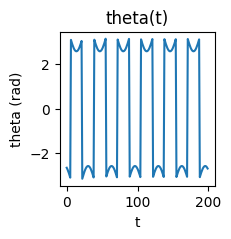

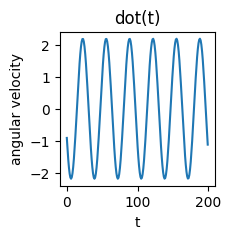

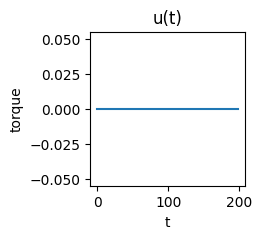

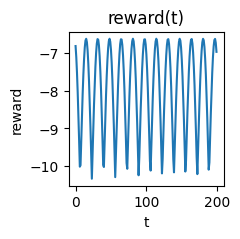

episode return: -1594.0328162006622


In [21]:
import gymnasium as gym
import numpy as np
import math
import matplotlib.pyplot as plt

from pendulum_residual_rl.controllers import EnergyPDController, obs_to_theta_theta_dot

env = gym.make("Pendulum-v1")

if False:
  print("using baseline control !!")
  ctrl = EnergyPDController()
  print(f"kp:{ctrl.kp}, kd:{ctrl.kd}, ke:{ctrl.ke}, theta_switch:{ctrl.theta_switch}")
else:
  print("using test control !!")
  ctrl = TestCtrl()

def rollout(seed=0, steps=200):
    obs, _ = env.reset(seed=seed)
    thetas, dots, us, rewards = [], [], [], []
    for _ in range(steps):
        u = ctrl(obs)
        obs, r, term, trunc, _ = env.step(u)
        theta, theta_dot = obs_to_theta_theta_dot(obs)
        thetas.append(theta)
        dots.append(theta_dot)
        us.append(float(u[0]))
        rewards.append(r)
        if term or trunc:
            break
    return np.array(thetas), np.array(dots), np.array(us), np.array(rewards)

if False:
  for i in (0,1,2,3,4,5):
    thetas, dots, us, rewards = rollout(seed=i, steps=200)
    print(f"episode {i} return:", rewards.sum())
else:
  thetas, dots, us, rewards = rollout(seed=3, steps=200)
  print_plots(thetas, dots, us, rewards)
  print("episode return:", rewards.sum())


In [11]:
# measure - eval over many episodes
import gymnasium as gym
import numpy as np
from pendulum_residual_rl.controllers import EnergyPDController

env = gym.make("Pendulum-v1")
ctrl = EnergyPDController()

def eval_controller(n_episodes=50, seed=0, steps=200):
    returns = []
    for i in range(n_episodes):
        obs, _ = env.reset(seed=seed + i)
        total = 0.0
        for _ in range(steps):
            action = ctrl(obs)
            obs, r, term, trunc, _ = env.step(action)
            total += r
            if term or trunc:
                break
        returns.append(total)
    return float(np.mean(returns)), float(np.std(returns))

mean_r, std_r = eval_controller(n_episodes=50, seed=0)
print("Baseline mean return:", mean_r)
print("Baseline std:", std_r)

Baseline mean return: -820.0159556004895
Baseline std: 620.7119080907681


In [13]:
for i, th in enumerate(thetas[:40]):
  print(f"{i}:{th}")

0:0.8623372145204976
1:0.8978254685056526
2:0.9645098370566759
3:1.0551227925203128
4:1.1633593412750594
5:1.2910261045384288
6:1.4397348130989542
7:1.610621913968565
8:1.8339792904919092
9:2.1085454094662355
10:2.4303189156405267
11:2.791572428076365
12:-3.1025000139048444
13:-2.702500013884929
14:-2.303441957743715
15:-1.9172616745146622
16:-1.5513531005513812
17:-1.2379374441750737
18:-0.9749634849601424
19:-0.7580275744029057
20:-0.5818725405869232
21:-0.44132713389220357
22:-0.3317994633422614
23:-0.2494872358125836
24:-0.18971203194877823
25:-0.1414075421217145
26:-0.09998678806905432
27:-0.06331202356062039
28:-0.03053416457667807
29:-0.0015975837016191084
30:0.023069321004527032
31:0.04349634877228149
32:0.06007453807106058
33:0.07331103264273822
34:0.08371224453962291
35:0.09173195957219274
36:0.09775442002895507
37:0.10209400972702624
38:0.10500181461708553
39:0.10667442392984984


In [14]:
for i, rw in enumerate(rewards[:70]):
  print(f"{i}:{rw}")

0:-0.761989540932331
1:-0.7442387858394676
2:-0.8565295386319812
3:-1.1089945465054643
4:-1.4457127546539006
5:-1.826010784388556
6:-2.3227004147041397
7:-2.961407625482968
8:-3.766199093792122
9:-5.36302066184012
10:-7.465426110551326
11:-10.051978044557586
12:-13.017039931399246
13:-15.685859344542948
14:-13.707506325902926
15:-11.679738292843197
16:-9.645300670115189
17:-7.766259779711904
18:-5.465664155496559
19:-3.7207658881863535
20:-2.461053288967432
21:-1.5837992449660607
22:-0.988890205516453
23:-0.593943330539573
24:-0.3363903974537531
25:-0.17925766306633495
26:-0.11337450315774865
27:-0.07864236461372345
28:-0.05785126213715515
29:-0.04403711327682746
30:-0.033810642195259664
31:-0.025333731104266937
32:-0.019116231568230762
33:-0.015158550740924768
34:-0.012936637110720642
35:-0.01187626076754629
36:-0.011512019224555584
37:-0.011514212140523986
38:-0.0116671513131882
39:-0.011837949248458204
40:-0.011949556093699921
41:-0.011960990583066504
42:-0.011865363329239188
43:-0.